# Rental Listing Prediction

### 10/24/2017

In [2]:
from __future__ import division
import random
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, log_loss
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from datetime import datetime as dt
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.graph_objs import *
from sklearn.externals import joblib
mapbox_access_token = 'pk.eyJ1IjoiYTk4MDUxODI3IiwiYSI6ImNqNWw2bHhteDJibDEzMG8xcDdhMjc0Z2cifQ.AquVYXuFpQ6ziPiOYg6F6A'

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_json('train.json')
df = df.reset_index()
df = df.drop(['index', 'listing_id'], 1)

In [4]:
df.head(4)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street


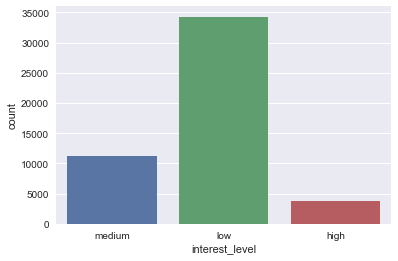

In [5]:
sns.countplot(x='interest_level', data=df)

## Remove outliers in terms of latitute and longitude

In [6]:
df = df[df['longitude']<-73.80]
df = df[df['longitude']>-74.05]
df = df[df['latitude']<40.9]
df = df[df['latitude']>40.6]

## Missing values

##### missing "# of bathrooms" and "# of bedrooms"

In [6]:
df['bathrooms'].loc[df[df['bathrooms']==0].index.tolist()] = np.nan
df['bedrooms'].loc[df[df['bedrooms']==0].index.tolist()] = np.nan
imp = Imputer(missing_values=np.nan, strategy='most_frequent', axis = 0)
X = imp.fit_transform(df[['bedrooms', 'bathrooms']])
df[['bathrooms', 'bedrooms']] = X

##### missing "building_id" (when building_id = 0)

In [7]:
print "The total number of building_id = 0 is " + str(sum(df.building_id=='0'))
print "This is a large amount of listings!"

The total number of building_id = 0 is 8246
This is a large amount of listings!


In [8]:
temp = df[df.building_id=='0'].groupby(['latitude', 'longitude'])
len(temp.count())

3533

##### Group all the listings with "building_id" = 0 by latitude and longitude

In [9]:
count = 100000
for i,j in temp:
    ind = j.index
    for index in ind:
        df.loc[index, ['building_id']] = count
    count+=1

## feature - manager_id

In [10]:
lbl = LabelEncoder()
lbl.fit(list(df['manager_id'].values))
df['manager_id'] = lbl.transform(list(df['manager_id'].values))

In [11]:
print 'There are a total of '+ str(len(df['manager_id'].unique())) + ' managers'

There are a total of 3459 managers


#### Compute the fraction of each interest level for all the managers

In [12]:
temp = pd.concat([df.manager_id, pd.get_dummies(df.interest_level)], axis=1).groupby('manager_id').mean()
temp.columns = ['m_high_frac','m_low_frac', 'm_medium_frac']
temp['m_count'] = df.groupby('manager_id').count().iloc[:,1]

In [13]:
temp.head(10)

,m_high_frac,m_low_frac,m_medium_frac,m_count
manager_id,,,,
0,0.0,0.333333,0.666667,12
1,0.0,1.000000,0.000000,10
2,0.0,1.000000,0.000000,1
3,0.0,0.000000,1.000000,2
4,0.0,0.666667,0.333333,3
5,0.0,1.000000,0.000000,3
6,0.0,1.000000,0.000000,1
7,0.0,1.000000,0.000000,1
8,0.0,1.000000,0.000000,3


#### Compute manager skills by using "skill = 2 * high_frac + medium frac" 

In [14]:
temp['m_skill'] = 2*temp['m_high_frac'] + temp['m_medium_frac']

In [15]:
unranked_managers_ixes = temp['m_count']<20
ranked_managers_ixes = ~unranked_managers_ixes

In [16]:
mean_values = temp.loc[ranked_managers_ixes, ['m_high_frac', 'm_low_frac', 'm_medium_frac']].mean()

In [17]:
mean_values

m_high_frac      0.081310
m_low_frac       0.674085
m_medium_frac    0.244605
dtype: float64

In [18]:
temp.loc[unranked_managers_ixes, ['m_high_frac', 'm_low_frac', 'm_medium_frac']] = mean_values.values

In [19]:
temp.head()

,m_high_frac,m_low_frac,m_medium_frac,m_count,m_skill
manager_id,,,,,
0,0.08131,0.674085,0.244605,12,0.666667
1,0.08131,0.674085,0.244605,10,0.000000
2,0.08131,0.674085,0.244605,1,0.000000
3,0.08131,0.674085,0.244605,2,1.000000
4,0.08131,0.674085,0.244605,3,0.333333


In [20]:
df = df.merge(temp.reset_index(), how='left', left_on = 'manager_id', right_on='manager_id')

In [21]:
df = df.drop(['manager_id'], axis=1)
df.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,photos,price,street_address,m_high_frac,m_low_frac,m_medium_frac,m_count,m_skill
0,3.0,1.5,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0.0,0.744444,0.255556,90,0.255556
1,2.0,1.0,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,-73.9667,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,0.0,0.988372,0.011628,86,0.011628


## feature - building_id

In [22]:
lbl.fit(list(df['building_id'].values))
df['building_id'] = lbl.transform(list(df['building_id'].values))

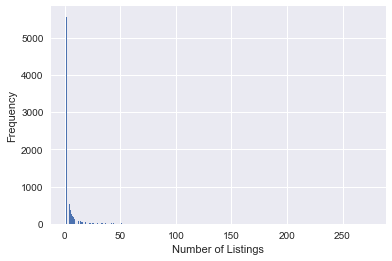

In [23]:
df.groupby('building_id').count()['bathrooms'].sort_values(ascending = False).plot(kind = 'hist', bins = 500)
plt.xlabel('Number of Listings')

In [24]:
temp = pd.concat([df.building_id, pd.get_dummies(df.interest_level)], axis = 1).groupby('building_id').mean()
temp.columns = ['b_high_frac', 'b_low_frac', 'b_medium_frac']

In [25]:
temp['b_count'] = df.groupby('building_id').count().iloc[:,1]
temp['bild_quality'] = 2*temp['b_high_frac'] + temp['b_medium_frac']
temp.head()

,b_high_frac,b_low_frac,b_medium_frac,b_count,bild_quality
building_id,,,,,
0,0.000000,1.000000,0.000000,1,0.000000
1,0.666667,0.000000,0.333333,3,1.666667
2,0.000000,0.000000,1.000000,1,1.000000
3,0.000000,1.000000,0.000000,1,0.000000
4,0.111111,0.333333,0.555556,9,0.777778


In [26]:
ranked_buildings_ixes = temp['b_count'] > 10
unranked_buildings_ixes = ~ranked_buildings_ixes

In [27]:
mean_values = temp.loc[ranked_buildings_ixes, ['b_high_frac', 'b_low_frac', 'b_medium_frac']].mean()
temp.loc[unranked_buildings_ixes, ['b_high_frac', 'b_low_frac', 'b_medium_frac']] = mean_values.values

In [28]:
temp.head()

,b_high_frac,b_low_frac,b_medium_frac,b_count,bild_quality
building_id,,,,,
0,0.063395,0.716912,0.219693,1,0.000000
1,0.063395,0.716912,0.219693,3,1.666667
2,0.063395,0.716912,0.219693,1,1.000000
3,0.063395,0.716912,0.219693,1,0.000000
4,0.063395,0.716912,0.219693,9,0.777778


In [29]:
df = df.merge(temp.reset_index(), how='left', left_on='building_id', right_on='building_id')
df = df.drop(['building_id'], axis=1)

In [30]:
df.head()

,bathrooms,bedrooms,created,description,display_address,features,interest_level,latitude,longitude,photos,...,m_high_frac,m_low_frac,m_medium_frac,m_count,m_skill,b_high_frac,b_low_frac,b_medium_frac,b_count,bild_quality
0,3.0,1.5,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,[https://photos.renthop.com/2/7211212_1ed4542e...,...,0.000000,0.744444,0.255556,90,0.255556,0.063395,0.716912,0.219693,3,0.333333
1,2.0,1.0,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,-73.9667,[https://photos.renthop.com/2/7150865_be3306c5...,...,0.000000,0.988372,0.011628,86,0.011628,0.000000,0.916667,0.083333,24,0.083333
2,1.0,1.0,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,-74.0018,[https://photos.renthop.com/2/6887163_de85c427...,...,0.059701,0.574627,0.365672,134,0.485075,0.172414,0.379310,0.448276,58,0.793103
3,1.0,1.0,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,-73.9677,[https://photos.renthop.com/2/6888711_6e660cee...,...,0.068063,0.806283,0.125654,191,0.261780,0.010101,0.898990,0.090909,99,0.111111
4,4.0,1.0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,-73.9493,[https://photos.renthop.com/2/6934781_1fa4b41a...,...,0.081310,0.674085,0.244605,15,0.000000,0.063395,0.716912,0.219693,1,0.000000


## feature - features

In [31]:
features = df["features"].apply(lambda _: ['_'.join(x.strip().lower().split(' ')) for x in _])
df["features"] = features
features.head()

0                                                   []
1    [doorman, elevator, fitness_center, cats_allow...
2    [laundry_in_building, dishwasher, hardwood_flo...
3                            [hardwood_floors, no_fee]
4                                            [pre-war]
Name: features, dtype: object

#### drop rare features (n < 5) and also try to deduplicate similar features

In [32]:
feature_counts = Counter()
for feature in features:
    feature_counts.update(feature)

In [33]:
n = 5
token = sorted([str(x) for (x,y) in feature_counts.items() if y > n])

In [34]:
token[0:10]

['24/7_concierge',
 '24/7_doorman',
 '24hr_doorman',
 'a_full_service_luxury_highrise',
 'actual_apt._photos',
 'air_conditioning',
 'all_utilities_included',
 'assigned-parking-space',
 'attended_lobby',
 'backyard']

In [35]:
print 'The number of features that we are going to use as our tokens: ' + str(len(token))

The number of features that we are going to use as our tokens: 209


In [36]:
token[0:10]

['24/7_concierge',
 '24/7_doorman',
 '24hr_doorman',
 'a_full_service_luxury_highrise',
 'actual_apt._photos',
 'air_conditioning',
 'all_utilities_included',
 'assigned-parking-space',
 'attended_lobby',
 'backyard']

In [56]:
temp = df['features'].apply(lambda _: [x if x in token else '' for x in _])
temp.head()

0                                                   []
1    [doorman, elevator, fitness_center, cats_allow...
2    [laundry_in_building, dishwasher, hardwood_flo...
3                            [hardwood_floors, no_fee]
4                                            [pre-war]
Name: features, dtype: object

In [74]:
for ind, features in enumerate(temp):
    text = ''
    for feature in features:
        if feature != '':
            text = " ".join([text, feature])
    temp[ind] = text

In [78]:
temp = pd.concat([temp, df.interest_level], axis = 1)
temp.head()

,features,interest_level
0,,medium
1,doorman elevator fitness_center cats_allowed ...,low
2,laundry_in_building dishwasher hardwood_floors,high
3,hardwood_floors no_fee,low
4,pre-war,low


In [86]:
corpus = temp.features.tolist()
vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(corpus)
y = temp.interest_level

In [90]:
clf = RandomForestClassifier(n_estimators=500)
scores = cross_val_score(clf, X, y=y, cv = 5)

In [91]:
scores

array([ 0.68689543,  0.68662797,  0.68897036,  0.68937774,  0.68723903])